## Getting started


OK, let's just dive right in and fill in details as we go. I'll be using Python for this exploration but will focus on the story and not the code. 

First things first, let's load the sunspots data, which is easy to find (e.g. [from NOAA](ftp://ftp.ngdc.noaa.gov/STP/SOLAR_DATA/SUNSPOT_NUMBERS/)) and conveniently included in a popular Python package for doing statistical work... 

In [1]:
import statsmodels.api as sm
import pandas as pd
data_loader = sm.datasets.sunspots.load_pandas()
df = data_loader.data

`df` is shorthand for "dataframe", which we can think of as an Excel-like table of values. Dataframes have various methods that can be called to easily learn about the data contained in them, and we'll step through calling some of these methods. Below, we see that we have 309 pairs of (year, activity) to examine... 

In [2]:
df

<class 'pandas.core.frame.DataFrame'>
Int64Index: 309 entries, 0 to 308
Data columns:
YEAR           309  non-null values
SUNACTIVITY    309  non-null values
dtypes: float64(2)

We can quickly inspect the first and last handful of values to get an idea of what the data look like...

In [3]:
df.head()

YEAR  SUNACTIVITY
0  1700            5
1  1701           11
2  1702           16
3  1703           23
4  1704           36

In [4]:
df.tail()

YEAR  SUNACTIVITY
304  2004         40.4
305  2005         29.8
306  2006         15.2
307  2007          7.5
308  2008          2.9

OK, so the time series of annual values starts in 1700 and goes through 2008. Notice that we have fractional numbers in the more recent observations. This got me wondering when these fractional values started appearing...

In [5]:
fractional_nums = df['SUNACTIVITY'].apply(lambda x: x % 1) #Take the modulo of each value with 1 to get the fractional part
fractional_nums[fractional_nums > 0].head()

49    0.9
50    0.4
51    0.7
52    0.8
53    0.7
Name: SUNACTIVITY

The first fractional value occurs in 1749. I looked into this a bit and (re)learned a few things:

* Galileo first documented sunspots in the early 1600s, using his newly invented _telescope_
* Reliable sunspot observations begin in about 1700
* The fractional numbers are probably associated with data coming out of Zurich, Switzerland in 1749 onward
* The methodology for tallying sunspot counts has evolved, most notably in 1848 with the introduction of the [Wolf number](http://en.wikipedia.org/wiki/Wolf_number) (which  is not simply an integer count)
* There seems to be a [fair bit of debate](http://www.leif.org/research/IAUS286-Mendoza-Svalgaard.pdf) about how accurate the existing data are

With some context in hand regarding the data generating process, let's get back to exploring the data. We can get a quick sense of the distribution of values...


In [6]:
print df['SUNACTIVITY'].describe()

count    309.000000
mean      49.752104
std       40.452595
min        0.000000
25%       16.000000
50%       40.000000
75%       69.800000
max      190.200000


...and of course, any time we report statistics we should try to provide an accompanying visualization (and vice versa)...

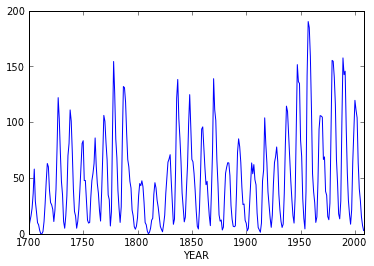

In [7]:
df.plot(x='YEAR', y='SUNACTIVITY', xlim=(1700,2008))

Clearly there is a seasonal pattern in activity. If our aim was to fit a model to these data we would want to start looking at the autocorrelation and partial autocorrelation functions...

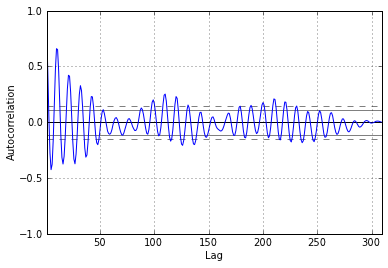

In [8]:
pd.tools.plotting.autocorrelation_plot(df['SUNACTIVITY'])

That the blue line goes beyond the horizontal grey lines indicates that this is a non-stationary time series with correlation structure. For my purposes here, I am not interested in fitting a model to the data. Instead, I just want to learn more about the length of the typical sunspot cycle. For this need it helps to view the time series' autocorrelation function in the _frequency_ domain instead of the temporal domain. So, we create an array of frequencies to evaluate the series over...

In [9]:
import numpy as np
N2 = df.shape[0] / 2
freqs = np.linspace(0, 0.5, num=N2, endpoint=False)[1:] #Nyquist range

...then, using these frequencies, plot the _periodogram_, which is the frequency domain analog of the autocorrelation plot above. Note that the [Lomb-Scargle method](http://en.wikipedia.org/wiki/Least-squares_spectral_analysis) used below assumes that the frequencies are not in a typical unit like Hertz (cycles per second) but rather as [angular frequencies](http://en.wikipedia.org/wiki/Angular_frequency), which is why we need to multiply the values by $2\pi$. (The Lomb-Scargle method is flexible in that the time series need not be uniformly sampled.)

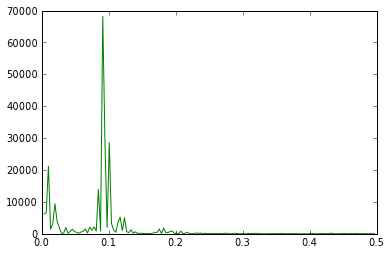

In [10]:
import scipy as sp
periodogram = sp.signal.lombscargle(df['YEAR'], df['SUNACTIVITY'], freqs * 2 * np.pi)
plt.plot(freqs, periodogram, color='green')

We see a big spike in the power of the series at a frequency of just below 0.1. Recall that these are yearly observations, so we can divide this frequency into 1 to get the period of each cycle...

In [11]:
freq_index_at_max_power = np.argmax(periodogram)
print 'Frequency and corresponding time in years at max power: %.2f, %.1f' % (freqs[freq_index_at_max_power], 1 / freqs[freq_index_at_max_power])

Frequency and corresponding time in years at max power: 0.09, 11.0


The major cycle is about 11 years, which is what the literature states. So, we could have skipped this previous step entirely and just assumed the data had an 11 year cycle like the literature said, but it is always good to sanity check what you are working with, and of course, in many settings one does not already know such things, hence the need for exploration.

At this point, after a handful of lines of code and some internet searches we have a basic handle on:

* The data generating process
* Distributional information
* Temporal behavior

There are a lot of things we could dive into further, but now comes the question that ties back to the title of this post: was our basic line plot of the time series data as helpful as it could be? After all, we simply plotted the data using default settings with respect to plot window size and axes scaling.

## Optimizing aspect ratio

In the following code segments we'll develop a method for finding _an_ optimal aspect ratio of the plot for the sunspots data (my use of the indefinite article rather than "the optimal" is purposeful: we just want to improve upon the default plot size and not necessarily find the truly best size). The code will follow the notation that Cleveland uses in the _The Details of Banking to 45$^\circ$_ section in [1].

The first thing we do is set up the vertical and horizontal range of the data we'll be plotting...

In [12]:
v_data = df['SUNACTIVITY'].max() - df['SUNACTIVITY'].min()
h_data = df['YEAR'].max() - df['YEAR'].min()
v_data_diffs = df['SUNACTIVITY'].diff().apply(np.abs)
vbar_data_diffs = v_data_diffs / v_data    
h_data_diffs = df['YEAR'].diff().apply(np.abs)
hbar_data_diffs = h_data_diffs / h_data

Next, we'll define our objective function that we want to optimize. This function gets evaluated for each aspect ratio we want to test, and for each evaluation it calls a few supporting functions...

In [13]:
def objective_fcn(width_height, target):
    dev = setup_device_coords(figsize=width_height)
    lengths = segment_lengths(dev['aspect ratio'], dev['horizontal_device'])
    weighted_avg_banking =  np.sum(segment_orientations(dev['aspect ratio']) * lengths) / np.sum(lengths)  
    return np.abs(weighted_avg_banking - target)

The `setup_device_coords` function maps data coordinates to screen coordinates and calculates the vertical and horizontal range of the data in terms of their screen positions...

In [14]:
def setup_device_coords(figsize=(8,6)):
    h_device, v_device = figsize
    fig, ax = plot_sunspots(figsize)
    device_coords = [ax.transData.transform(data_coords) for data_coords in df.values]
    df_device = pd.DataFrame(device_coords, columns=['YEAR', 'SUNACTIVITY'])    
    v_device = df_device['SUNACTIVITY'].max() - df_device['SUNACTIVITY'].min()
    h_device = df_device['YEAR'].max() - df_device['YEAR'].min()
    aspect_ratio = v_device / h_device
    v_conversion = v_device / v_data  
    h_conversion = h_device / h_data
    fig.clear()
    return {'aspect ratio': aspect_ratio,
            'vertical_device': v_device,
            'horizontal_device': h_device,
            'vertical conversion': v_conversion,
            'horizontal conversion': h_conversion}

To do the data-to-screen conversion the `setup_device_coords` function calls a supporting function to render a plot of the data in device memory...

In [15]:
def plot_sunspots(figsize, color='blue'):
    fig = plt.figure(figsize=figsize)
    fig.canvas.set_window_title('%.1f by %.1f inch window' % (figsize[0], figsize[1]))
    ax1 = fig.add_subplot(111)
    df.plot(x='YEAR', y='SUNACTIVITY', ax=ax1, linewidth=2, color=color)
    fig.tight_layout()
    ax1.set_xlim(right=df['YEAR'].max())
    ax1.set_ylim(top=df['SUNACTIVITY'].max())
    ax1.set_ylabel('Observed Sunspots')
    ax1.set_title('Sunspot Activity Over Time')
    return (fig, ax1)

Back to the supporting functions called by `objective_fcn`, we need to deteremine the lengths and slopes of each line segment in a given plot. The banking method calculates the average orientation of the line segments, where the averaging is weighted by each line segment's length.

In [16]:
def segment_lengths(aspect_ratio, h_device):
    return h_device * np.sqrt(hbar_data_diffs.dropna()**2 + aspect_ratio**2 * vbar_data_diffs.dropna()**2)

In [17]:
def segment_orientations(aspect_ratio):
    return np.arctan(aspect_ratio * vbar_data_diffs / hbar_data_diffs)

With the objective function (and its supporting functions) defined, we now need a few lines of code to drive everything. We set our desired average banking of the line segments to be 45 degrees (although the algorithms work in units of radians) and then define a grid of possible plot sizes to evaluate the objective function over. Note that the optimization method is called `brute` for a reason: it is a just a brute-force scan of every possible plot size, where we have defined what is possible. Since I already have experience with these data I am limiting the search to be over plotting windows that are longer than they are tall, and I am only searching over $\frac{1}{2}$ inch step-sizes in the window dimensions because we are not interested in a super-precise solution. The last line of code unpacks a list of values returned in the `results` variable into individual variables that we can work with directly.

In [18]:
import scipy.optimize as spo
target = np.radians(45)   
slice_obj = np.s_[20:26:0.5, # widths
                  1:4:0.5]   # heights              
results = spo.brute(objective_fcn, slice_obj, args=[target], full_output=True, finish=None)
optimal_dims, objective_val, search_grid, objective_grid = results

With the optimal plot size determined, let's compare how the time series plot looks using the default aspect ratio versus the optimized one...



Weighted-average banking using default 8 x 6 inch plot window: 87.3 degrees (goal is 45 degrees)


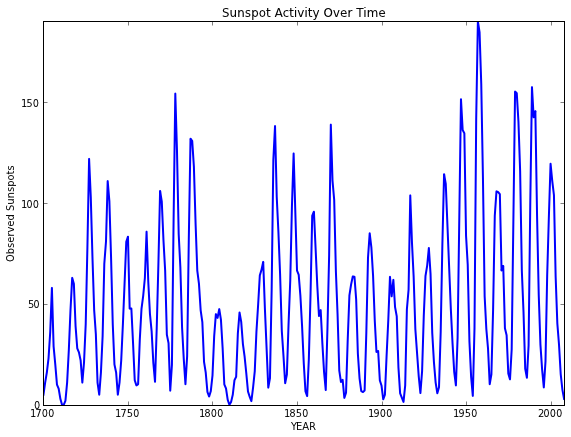

In [19]:
plt.close('all')
ax1 = plot_sunspots((8,6))
print '\n\nWeighted-average banking using default 8 x 6 inch plot window: 87.3 degrees (goal is 45 degrees)' 

This is the same plot we saw above, but bigger and with axes labels. The default aspect ratio leaves us with line segments that have an average orientation of _nearly vertical_, so this is a perfect example of the type of problem Cleveland was researching: It is very difficult to perceive patterns in the data when the rates of change over small chunks of time are so extreme. About all we can say is "there are cycles roughly every 10 years".

Now let's look at the same data plotted using an aspect ratio that makes the average line segment have an absolute orientation of 45 degrees...



Optimal width and height found to be 25.0 by 1.5 inches
Average banking interval at optimized aspect ratio: (44.91, 45.09)


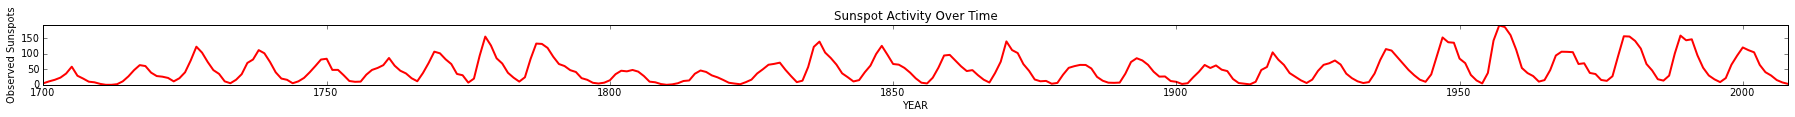

In [20]:
ax2 = plot_sunspots(optimal_dims, color='red')
print '\n\nOptimal width and height found to be %.1f by %.1f inches' % (optimal_dims[0], optimal_dims[1])    
banking = [np.degrees(target - objective_val),
           np.degrees(target + objective_val)]    
print 'Average banking interval at optimized aspect ratio: (%.2f, %.2f)' % (banking[0], banking[1])

(When I run this same code on my laptop I get an optimal width of 22.5 inches by the same 1.5 inch height.)

Ah, now we see something **entirely new**: when there are large spikes in activity the ramp up period is asymmetric with the ramp down period. Specifically, activity ramps up very quickly and tapers off more gradually. In contrast, during weaker cycles the pattern is more symmetric. This nonlinear behavior is interesting and highly studied. But, we might never investigate further had we simply plotted the data in a naive way and moved on to something else.

## Lessons
1. Even the most pedestrian data task, like plotting an array of values, still requires careful thought if the aim is gaining insight. Without such thought it is remarkably easy to have one's work amount to little more than generating chart porn for PowerPoint decks

2. Default settings in visualization tools are there for expediency. We will encounter plenty of opportunities that warrant going beyond these _defaults_ to instead put _intention_ behind our graphical results

## Extensions

The exploration presented here was a quick first take and there a couple of places we could improve upon. First, the method that Cleveland developed ~ 20 years ago has seen extensions, such as [_multiscale banking_](http://vis.berkeley.edu/papers/banking/). Second, the optimization method was easy to use and understand, but a more general, faster-converging approach is certainly possible.

## About this post 

This **entire** post (executable code, results, surrounding text, and text formatting) was created using the [IPython Notebook](http://ipython.org/ipython-doc/dev/interactive/htmlnotebook.html), an amazing extension of IPython[2] that supports highly interactive, collaborative, and reproducible numerical computing. For the many cases in which I want my code to be linked with rich context, it is hard to see _not_ using the Notebook. If your use case is focused more on text, with a bit of code interlaced, then using tools like [Sweave](http://www.stat.uni-muenchen.de/~leisch/Sweave/) in R or [Pweave](http://mpastell.com/pweave/) in Python are excellent options for supporting transparent, reproducible work (John Cook has a nice [blog post](http://www.johndcook.com/blog/2012/12/20/basics-of-sweave-and-pweave/) about this nuanced difference in use cases). In either case, there are no longer excuses for not tightly coupling code, analytical results, and context `:)`

The notebook file can be downloaded directly from a [Gist](https://gist.github.com/4597218) on my GitHub account. If you do not use Python you can still view the file using the free, web-based [IPython Notebook Viewer](http://nbviewer.ipython.org/), which is how you areviewing this part of the post.

If you dabble in building on this exploration, please share it!

## References

[1] _The Elements of Graphing Data_, William S. Cleveland, Hobart Press, Summit, New Jersey, 1994
    ISBN: 0-9634884-1-4     
[2] _IPython: A System for Interactive Scientific Computing_, Fernando PÃ©rez, Brian E. Granger, Computing in Science and Engineering, vol. 9, no. 3, pp. 21-29, May/June 2007, doi:10.1109/MCSE.2007.53. URL: http://ipython.org


**[Back to Part 1](http://ficolabsblog.fico.com/2013/01/a-moment-of-science-just-plot-it.html)**

**[Back to FICO Labs](http://ficolabsblog.fico.com/)**